In [1]:
cd cmput_651_final/

/home/zeyi/work_station/gpu/cmput_651_final


In [2]:
%run init.ipynb

selected_worlds = get_selected()
world = selected_worlds['den020d.map']

roads = list(filter(lambda t: world.get(t) == World.ROAD, world))
idx_to_pos = dict(enumerate(roads))
vocab_size = len(idx_to_pos)
pos_to_idx = {v: k for k, v in idx_to_pos.items()}
print('vocab_size:', vocab_size)

maps/selected
maps/selected/selected-map/lak110d.map
maps/selected/selected-map/den020d.map
maps/selected/selected-map/den005d.map
maps/selected/selected-map/ost102d.map
maps/selected/selected-map/den001d.map

vocab_size: 3102


In [3]:
model = torch.load('den020d.map_LargeEmbedModel_2.pt', map_location=torch.device('cpu'))

In [4]:
summary(model, input_size=(1, 2), dtypes=[torch.int64], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 1, 2, 64]         198,528
            Linear-2                 [-1, 1024]         132,096
           Dropout-3                 [-1, 1024]               0
            Linear-4                 [-1, 3102]       3,179,550
   LargeEmbedModel-5                 [-1, 3102]               0
Total params: 3,510,174
Trainable params: 3,510,174
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 13.39
Estimated Total Size (MB): 13.45
----------------------------------------------------------------



(tensor(3510174), tensor(3510174))

In [5]:
# for _ in range(20):
#     model.to('cpu')
#     model.eval()
#     with torch.no_grad():
#         start = random.choice(roads)
#         goal = random.choice(list(set(roads) - set([start])))
#         subgoal = get_subgoal(model, start, goal)
#         Vis([
#             BitmapLayer(world.bitmap),
#             SceneLayer(start, goal),
#             SubgoalLayer([subgoal])
#         ]).display()

In [6]:
class GIF(object):
    def __init__(self, images):
        self.images = images
        
    def display(self, save=False, fps=60, show=True):
        if save:
            fname = 'temp_images/' + str(uuid.uuid4()) + '.gif'
        else:
            fname = '/tmp/.tmp.gif'
        imageio.mimsave(fname, self.images, fps=fps)
        if show:
            display.display(display.Image(filename=fname))

In [22]:
@dataclass()
class ReplayRecord(object):
    start: Pos
    goal: Pos
    path: list
    h_updates: list = field(default_factory=list)
    subgoals: list = field
    num_fallbacks: int
    time: float=0
        
    @property
    def cost(self):
        return len(path.poses) - 1
        
    def gif(self):
        images = []
        for i in range(len(self.path.poses)):
            vis = Vis([
                BitmapLayer(world.bitmap),
                SceneLayer(self.start, self.goal),
            ], 4)
            if self.subgoals:
                layer = SubgoalLayer([self.subgoals[i]] if self.subgoals else [])
                vis.layers.append(layer)
            if self.path:
                layer = PathLayer(self.path.poses[:i])
                vis.layers.append(layer)
            if self.h_updates:
                layer = ColorOverlayLayer(normalize_alpha(np.log1p(self.h_updates[i].astype(np.float32)))),
                vis.layers.append(layer)
            images.append(vis.get_image())
        return GIF(images)

TypeError: non-default argument 'subgoals' follows default argument

In [17]:
from timeit import timeit
class Timer(object):
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.timer = timeit
        
    def __enter__(self):
        self.start = self.timer()
        return self
        
    def __exit__(self, *args):
        end = self.timer()
        self.elapsed_secs = end - self.start
        self.elapsed = self.elapsed_secs * 1000  # millisecs
        if self.verbose:
            print('elapsed time: %f ms' % self.elapsed)

In [18]:
def run_algo(world, start, goal, algo):
    with Timer() as timer:
        algo.init_h(world, goal)
        curr_pos = start
        total_cost = 0
        path = [curr_pos]
#         h_updates = [algo.h_updates.copy()]
        while curr_pos != goal:
    #         print(curr_pos)
            next_pos = algo.get_next_pos(curr_pos, goal, world)
            assert world.is_adj(curr_pos, next_pos)
            total_cost += world.get_cost(curr_pos, next_pos)
            path.append(next_pos)
#             h_updates.append(algo.h_updates.copy())
            curr_pos = next_pos
    return ReplayRecord(
        start=start,
        goal=goal,
        path=Path(world, start, goal, path),
        subgoals=[],
#         h_updates=h_updates,
        num_fallbacks=0,
        time=timer.elapsed
    )

In [19]:
def run_nnhcs(world, start, goal, model, verbose=False):
    with Timer() as timer:
        lrta = LRTA(weight=8)
        lrta.init_h(world, goal)

        curr = start
        final_poses = [curr]
#         h_updates = [lrta.h_updates.copy()]
        subgoals = [curr]
        subgoal = start
        visit_count = np.zeros_like(world.bitmap)
        num_fallbacks = 0

    #     while curr != goal and num_steps < 300:
        while curr != goal:
            if visit_count[curr.x, curr.y] > 1:
    #             for _ in range(5):
                num_fallbacks += 1
                curr = lrta.get_next_pos(curr, goal, world)
                if curr == goal:
                    break
                final_poses.append(curr)
#                 h_updates.append(lrta.h_updates.copy())
                subgoals.append(subgoal)
                visit_count[curr.x, curr.y] += 1
            else:
                subgoal = get_subgoal(model, curr, goal)
                if subgoal == curr:
                    visit_count[curr.x, curr.y] += 1
                    continue
                poses = hill_climb(world, curr, subgoal, goal, num_steps=5)
                for pos in poses:
                    if pos != curr:
                        visit_count[pos.x, pos.y] += 1
                        final_poses.append(pos)
#                         h_updates.append(lrta.h_updates.copy())
                        subgoals.append(subgoal)
                curr = poses[-1]

        if curr == goal and final_poses[-1] != goal:
            final_poses.append(goal)
            subgoals.append(goal)
#             h_updates.append(lrta.h_updates.copy())
        
    return ReplayRecord(
        start=start,
        goal=goal,
        path=Path(world, start, goal, final_poses, subgoals),
        subgoals=subgoals,
#         h_updates=h_updates,
        num_fallbacks=num_fallbacks,
        time=timer.elapsed
    )

In [20]:
random.seed(1)
scenes = []
for _ in range(1000):
    start = random.choice(roads)
    goal = random.choice(list(set(roads) - set([start])))
    scenes.append((start, goal))

In [21]:
nnhcs_records = []
for start, goal in tqdm_nb(scenes):
    record = run_nnhcs(world, start, goal, model)
    nnhcs_records.append(record)

TypeError: __init__() missing 1 required positional argument: 'h_updates'

In [13]:
lrta_records = []
for start, goal in tqdm_nb(scenes):
    lrta = LRTA(weight=8)
    record = run_algo(world, start, goal, lrta)
    lrta_records.append(record)
    del lrta
    gc.collect()

KeyboardInterrupt: 

In [ ]:
opt_records = []
for start, goal in tqdm_nb(scenes):
    with Timer() as timer:
        opt_path = get_opt_path(world, start, goal)
    record = ReplayRecord(
        start=start,
        goal=goal,
        path=opt_path,
        subgoals=None,
        h_updates=None,
        num_fallbacks=0,
        time=timer.elapsed
    )
    opt_records.append(record)

In [ ]:
nnhcs_subopts = []
for nnhcs_record, opt_record in zip(nnhcs_records, opt_records):
    subopt = round(nnhcs_record.cost / opt_record.cost, 3)
    nnhcs_subopts.append(subopt)

In [ ]:
lrta_subopts
for lrta_record, opt_record in zip(lrta_records, opt_records):
    subopt = round(lrta_record.cost / opt_record.cost, 3)
    lrta_subopts.append(subopt)

In [121]:
# subs = []
# lrta_subs = []
# lrta_times = []
# for record in tqdm_nb(records):
#     opt = len(get_opt_path(world, record.start, record.goal).poses) - 1
#     mine = len(record.path.poses) - 1
#     suboptimality = round(mine / opt - 1, 2)
#     subs.append(suboptimality)
#     with Timer() 
#     lrta_cost = len(run(world, record.start, record.goal, lrta).path.poses) - 1
#     lrta_sub = round(lrta_cost / opt - 1, 2)
#     lrta_subs.append(lrta_sub)

In [122]:
print(np.mean(subs))
print(min(subs), max(subs))
print(np.mean(lrta_subs))

0.03777
0.0 3.75
2.4232


In [118]:
collections.Counter(subs)

Counter({0.0: 853,
         0.09: 6,
         0.21: 5,
         1.35: 1,
         0.05: 2,
         0.07: 11,
         0.31: 1,
         0.04: 6,
         0.28: 5,
         0.38: 2,
         0.1: 4,
         0.03: 12,
         0.26: 2,
         0.41: 2,
         0.44: 1,
         0.52: 1,
         0.43: 1,
         0.06: 5,
         0.96: 1,
         0.08: 5,
         0.01: 3,
         0.5: 2,
         0.16: 2,
         0.73: 1,
         0.02: 9,
         0.46: 1,
         0.19: 3,
         0.17: 3,
         0.54: 2,
         0.33: 1,
         1.7: 1,
         0.29: 2,
         0.45: 1,
         3.75: 1,
         0.27: 1,
         0.12: 2,
         0.14: 4,
         1.04: 1,
         0.13: 5,
         0.15: 1,
         0.42: 2,
         0.75: 1,
         0.25: 1,
         0.22: 1,
         0.18: 4,
         0.87: 1,
         0.11: 4,
         0.53: 1,
         1.3: 1,
         0.65: 1,
         0.67: 1,
         0.47: 1,
         0.64: 1,
         0.34: 1,
         0.23: 1,
         0.

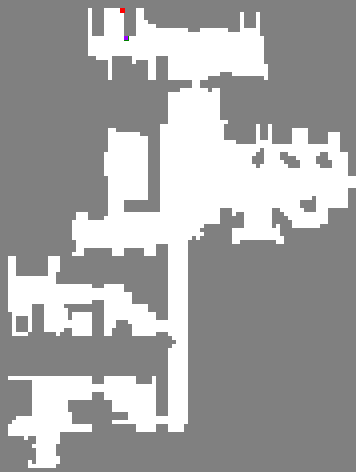

In [114]:
worst_record = records[subs.index(max(subs))]
worst_record.gif().display(fps=10)

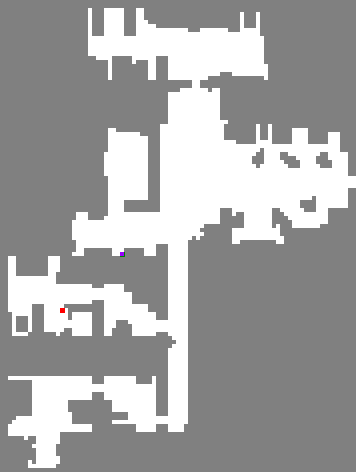

In [115]:
random.choice(records).gif().display(fps=10)